### Instructions:
* Download the cifar_net.pth model and set the PATH variable in this notebook to the appropriate path of the cifar_net.pth file.
* Executing this notebook creates multiple copies of the unpruned model for trying out the various built-in model pruning techniques available in PyTorch:
  * net1 is the Unpruned model
  * net2 is for Random Unstructured Pruning
  * net3 is for L1 Unstructured Pruning
  * net4 is for Random Structured Pruning
  * net5 is for Ln Structured Pruning
  * net6 is for Pruning multiple parameters
  * net7 is for Global Pruning
  * net8 is for Custom Pruning 
* One model among net2 to net8 (based on what is assigned to the variable "net" in the model testing section of this notebook) is tested for its accuracy (no. of correct classifications/total no. of classifications) on the test set of cifar10.

> CIFAR10 dataset has 10 classes - ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

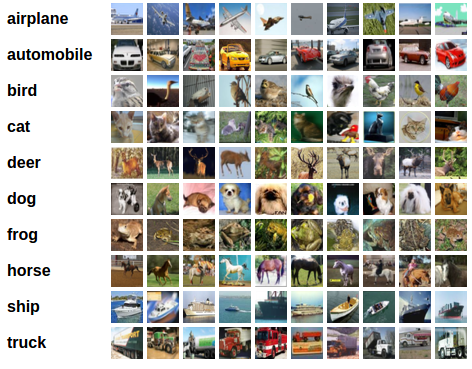

# Selecting device

In [128]:
import torch 

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Loading and normalizing images using TorchVision


In [129]:
import torchvision
import torchvision.transforms as transforms

In [130]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# General function to test a model

In [131]:
import numpy as np

def test_model(model):
    model.eval()
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = []
    #GPU-WARM-UP
    i=0
    for data in testloader:
        if(i>1000):
            break
        images, labels = data
        images = images.to(device)
        _ = model(images)
        i += 1
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            starter.record()
            outputs = model(images)
            ender.record()
            
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: '+str(100 * (correct / total))+"%")
    
    tot = np.sum(timings)
    mean_syn_per_batch = np.sum(timings) / len(timings)
    std_syn_per_batch = np.std(timings)
    print("Total inference time for test data: "+str(tot)+" milliseconds")
    print("Mean inference time per test batch: "+str(mean_syn_per_batch)+" milliseconds")
    print("Standard deviation of inference times per batch: "+str(std_syn_per_batch)+" milliseconds")
    model.train()

# Displaying some images

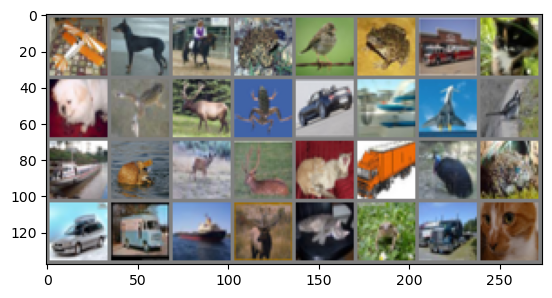

plane   dog horse  frog


In [132]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining a Convolutional Neural Network

In [133]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.bn1 = nn.BatchNorm2d(256).to(device)
        self.conv2 = nn.Conv2d(256, 512, 3).to(device)
        self.bn2 = nn.BatchNorm2d(512).to(device)
        self.conv3 = nn.Conv2d(512, 1024, 3).to(device)
        self.bn3 = nn.BatchNorm2d(1024).to(device)
        self.fc1 = nn.Linear(1024 * 2 * 2, 2048).to(device)
        self.fc2 = nn.Linear(2048, 512).to(device)
        self.fc3 = nn.Linear(512, 10).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)).to(device))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)).to(device))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)).to(device))
        x = self.bn3(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1).to(device)
        return x


net = Net()

In [134]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 6912
conv1.bias 	 256
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402


# Now we will load our model

In [135]:
PATH = './cifar_net.pth'

net1 = Net() #Unpruned model
net2 = Net() #For Random Unstructured Pruning
net3 = Net() #For L1 Unstructured Pruning
net4 = Net() #For Random Structured Pruning
net5 = Net() #For Ln Structured Pruning
net6 = Net() #For Pruning multiple parameters
net7 = Net() #For Global Pruning
net8 = Net() #For Custom Pruning

net1.load_state_dict(torch.load(PATH))
net2.load_state_dict(torch.load(PATH))
net3.load_state_dict(torch.load(PATH))
net4.load_state_dict(torch.load(PATH))
net5.load_state_dict(torch.load(PATH))
net6.load_state_dict(torch.load(PATH))
net7.load_state_dict(torch.load(PATH))
net8.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Pruning the model

In [136]:
import torch.nn.utils.prune as prune

## Inspecting the conv1 layer

In [137]:
module = net1.conv1
#print(list(module.named_parameters()))

In [138]:
#print(list(module.named_buffers()))

## Random Unstructured Pruning

**Randomly prune 40% of the connections in the parameter named weight**

In [139]:
module = net2.conv1
prune.random_unstructured(module, name="weight", amount=0.4)
prune.random_unstructured(module, name="bias", amount=0.4)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

**The pruning mask:**

In [140]:
#print(list(module.named_buffers()))

**weight is now an just an attribute of the module**

In [141]:
#print(module.weight)

In [142]:
print(module._forward_pre_hooks)

OrderedDict([(152, <torch.nn.utils.prune.RandomUnstructured object at 0x7f0227f5a530>), (153, <torch.nn.utils.prune.RandomUnstructured object at 0x7f0227f593f0>)])


## L1 Unstructured Pruning

**Prune 40% of entries based on minimum L1 norm**

In [143]:
module = net3.conv1
prune.l1_unstructured(module, name="weight", amount=0.4)
prune.l1_unstructured(module, name="bias", amount=0.4)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [144]:
print(module._forward_pre_hooks)

OrderedDict([(154, <torch.nn.utils.prune.L1Unstructured object at 0x7f0227f595a0>), (155, <torch.nn.utils.prune.L1Unstructured object at 0x7f0227f59420>)])


## Random Structured Pruning

**Prune 41.479% of the channels**

In [145]:
module = net4.conv1
prune.random_structured(module, name="weight", amount=0.41479, dim=0)
prune.remove(module, "weight")

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [146]:
print(module._forward_pre_hooks)

OrderedDict()


## Ln Structured Pruning

**Pruning 41.479% of the channels based on the channels' L1 norm**

In [147]:
module = net5.conv1
prune.ln_structured(module, name="weight", amount=0.41479, n=1, dim=0)
prune.remove(module, "weight")

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [148]:
print(module._forward_pre_hooks)

OrderedDict()


## Pruning multiple parameters in the model

**Using l1_unstructured, prune 30% of connections in all Conv2D layers and prune 40% of the connections in all Linear layers**

In [149]:
for name, module in net6.named_modules():
    # prune 30% of connections in all Conv2D layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.3)
        prune.l1_unstructured(module, name='bias', amount=0.3)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)
        prune.l1_unstructured(module, name='bias', amount=0.4)

print(dict(net6.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['conv1.weight_mask', 'conv1.bias_mask', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight_mask', 'conv2.bias_mask', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight_mask', 'conv3.bias_mask', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'fc1.weight_mask', 'fc1.bias_mask', 'fc2.weight_mask', 'fc2.bias_mask', 'fc3.weight_mask', 'fc3.bias_mask'])


## Global Pruning

**Pruning 75% of connections across the whole model based on lowest L1 norm**

In [150]:
parameters_to_prune = (
    (net7.conv1, 'weight'),
    (net7.bn1, 'weight'),
    (net7.conv2, 'weight'),
    (net7.bn2, 'weight'),
    (net7.conv3, 'weight'),
    (net7.bn3, 'weight'),
    (net7.fc1, 'weight'),
    (net7.fc2, 'weight'),
    (net7.fc3, 'weight'),
    (net7.conv1, 'bias'),
    (net7.bn1, 'bias'),
    (net7.conv2, 'bias'),
    (net7.bn2, 'bias'),
    (net7.conv3, 'bias'),
    (net7.bn3, 'bias'),
    (net7.fc1, 'bias'),
    (net7.fc2, 'bias'),
    (net7.fc3, 'bias')
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.75,
)

Now we can check the sparsity induced in every pruned parameter, which will not be equal to 20% in each layer. However, the global sparsity will be (approximately) 20%.

In [151]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv1.weight == 0))
        / float(net7.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv2.weight == 0))
        / float(net7.conv2.weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv3.weight == 0))
        / float(net7.conv3.weight.nelement())
    )
)
print(
    "Sparsity in bn1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn1.weight == 0))
        / float(net7.bn1.weight.nelement())
    )
)
print(
    "Sparsity in bn2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn2.weight == 0))
        / float(net7.bn2.weight.nelement())
    )
)
print(
    "Sparsity in bn3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn3.weight == 0))
        / float(net7.bn3.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc1.weight == 0))
        / float(net7.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc2.weight == 0))
        / float(net7.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc3.weight == 0))
        / float(net7.fc3.weight.nelement())
    )
)
print(
    "Sparsity in conv1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv1.bias == 0))
        / float(net7.conv1.bias.nelement())
    )
)
print(
    "Sparsity in conv2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv2.bias == 0))
        / float(net7.conv2.bias.nelement())
    )
)
print(
    "Sparsity in conv3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv3.bias == 0))
        / float(net7.conv3.bias.nelement())
    )
)
print(
    "Sparsity in bn1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn1.bias == 0))
        / float(net7.bn1.bias.nelement())
    )
)
print(
    "Sparsity in bn2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn2.bias == 0))
        / float(net7.bn2.bias.nelement())
    )
)
print(
    "Sparsity in bn3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn3.bias == 0))
        / float(net7.bn3.bias.nelement())
    )
)
print(
    "Sparsity in fc1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc1.bias == 0))
        / float(net7.fc1.bias.nelement())
    )
)
print(
    "Sparsity in fc2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc2.bias == 0))
        / float(net7.fc2.bias.nelement())
    )
)
print(
    "Sparsity in fc3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc3.bias == 0))
        / float(net7.fc3.bias.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(net7.conv1.weight == 0)
            + torch.sum(net7.conv2.weight == 0)
            + torch.sum(net7.conv3.weight == 0)
            + torch.sum(net7.bn1.weight == 0)
            + torch.sum(net7.bn2.weight == 0)
            + torch.sum(net7.bn3.weight == 0)
            + torch.sum(net7.fc1.weight == 0)
            + torch.sum(net7.fc2.weight == 0)
            + torch.sum(net7.fc3.weight == 0)
            + torch.sum(net7.conv1.bias == 0)
            + torch.sum(net7.conv2.bias == 0)
            + torch.sum(net7.conv3.bias == 0)
            + torch.sum(net7.bn1.bias == 0)
            + torch.sum(net7.bn2.bias == 0)
            + torch.sum(net7.bn3.bias == 0)
            + torch.sum(net7.fc1.bias == 0)
            + torch.sum(net7.fc2.bias == 0)
            + torch.sum(net7.fc3.bias == 0)
        )
        / float(
            net7.conv1.weight.nelement()
            + net7.conv2.weight.nelement()
            + net7.conv3.weight.nelement()
            + net7.bn1.weight.nelement()
            + net7.bn2.weight.nelement()
            + net7.bn3.weight.nelement()
            + net7.fc1.weight.nelement()
            + net7.fc2.weight.nelement()
            + net7.fc3.weight.nelement()
            +net7.conv1.bias.nelement()
            + net7.conv2.bias.nelement()
            + net7.conv3.bias.nelement()
            + net7.bn1.bias.nelement()
            + net7.bn2.bias.nelement()
            + net7.bn3.bias.nelement()
            + net7.fc1.bias.nelement()
            + net7.fc2.bias.nelement()
            + net7.fc3.bias.nelement()
        )
    )
)

Sparsity in conv1.weight: 16.23%
Sparsity in conv2.weight: 72.81%
Sparsity in conv3.weight: 74.64%
Sparsity in bn1.weight: 0.00%
Sparsity in bn2.weight: 0.00%
Sparsity in bn3.weight: 0.00%
Sparsity in fc1.weight: 75.54%
Sparsity in fc2.weight: 75.71%
Sparsity in fc3.weight: 51.15%
Sparsity in conv1.bias: 16.80%
Sparsity in conv2.bias: 4.49%
Sparsity in conv3.bias: 3.42%
Sparsity in bn1.bias: 5.08%
Sparsity in bn2.bias: 7.81%
Sparsity in bn3.bias: 31.25%
Sparsity in fc1.bias: 5.81%
Sparsity in fc2.bias: 92.77%
Sparsity in fc3.bias: 70.00%
Global sparsity: 75.00%


## Custom Pruning

**A pruning technique that prunes every other entry in a tensor (or – if the tensor has previously been pruned – in the remaining unpruned portion of the tensor). This will be of PRUNING_TYPE='unstructured' because it acts on individual connections in a layer and not on entire units/channels ('structured'), or across different parameters ('global').**

In [152]:
class CustomPruningMethod(prune.BasePruningMethod):
    """Prune every other entry in a tensor
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        mask.view(-1)[::2] = 0
        return mask
    
def custom_unstructured(module, name):
    CustomPruningMethod.apply(module, name)
    return module

In [153]:
custom_unstructured(net8.conv1, name='weight')
custom_unstructured(net8.conv1, name='bias')

print(net8.conv1.weight_mask)
print(net8.conv1.bias_mask)

tensor([[[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]],


        [[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]],


        ...,


        [[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 

# Select a model to be tested

In [ ]:
net = net5   # SELECT THE MODEL TO BE TESTED

# Filter Visualisations

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

def plot_filters_single_channel_big(t):
    t=t.cpu()
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)
    
def plot_filters_single_channel(t):
    t=t.cpu()
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = np.abs(npimg)
            npimg[npimg != 0] += 0.2
            npimg = (npimg - 0) / (np.max(npimg) - 0)
            npimg = np.minimum(1, np.maximum(0, npimg))
            npimg = 1 - npimg
            ax1.imshow(npimg, cmap='gray', vmin=0, vmax=1)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    
def plot_filters_multi_channel(t):
    t=t.cpu()
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        npimg = np.abs(npimg)
        npimg[npimg != 0] += 0.2
        npimg = (npimg - 0) / (np.max(npimg) - 0)
        npimg = np.minimum(1, np.maximum(0, npimg))
        npimg = 1 - npimg
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('./Conv1_filters.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def visualiseConv1(model, single_channel = True, collated = False):
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.Conv2d)):
            weight_tensor = module.weight.data
            if single_channel:
              if collated:
                plot_filters_single_channel_big(weight_tensor)
              else:
                plot_filters_single_channel(weight_tensor)
        
            else:
              if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
              else:
                print("Can only plot weights with three channels with single channel = False")
            break

## Visualising conv filters of the unpruned model

In [ ]:
#Syntax for label of each subplot: (filter_number, channel_number_of_filter)
visualiseConv1(net1)

## Visualising conv filters of the pruned model (with zeroed weights)

In [ ]:
#Syntax for label of each subplot: (filter_number, channel_number_of_filter)
visualiseConv1(net)

# Let's test the accuracy of the unpruned model

In [154]:
test_model(net1)

Accuracy of the network on the 10000 test images: 79.67%
Total inference time for test data: 1313.8911392688751 milliseconds
Mean inference time per test batch: 4.197735269229633 milliseconds
Standard deviation of inference times per batch: 0.6253286951839987 milliseconds


# Let's test the accuracy of the pruned model

Choose one model among net2 to net8 and assign it to the variable "net" in the following cell. Executing the rest of the code would test the accuracy (no. of correct classifications/total no. of classifications) of the chosen model.
 
Note:
* net1 is the Unpruned model
* net2 is for Random Unstructured Pruning
* net3 is for L1 Unstructured Pruning
* net4 is for Random Structured Pruning
* net5 is for Ln Structured Pruning
* net6 is for Pruning multiple parameters
* net7 is for Global Pruning
* net8 is for Custom Pruning

In [155]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

total_params = 0
pruned_params = 0

flag = 0
for name, module in net.named_modules():
    if flag == 0:
        flag = 1 
        continue
    try:
        total_params += module.weight.nelement()
        total_params += module.bias.nelement()
        
        pruned_params += torch.sum(module.weight == 0).item()
        pruned_params += torch.sum(module.bias == 0).item()
    except AttributeError:
        pass
    
print("")
print("Parameters pruned: "+str(pruned_params))
print("Remaining parameters: "+str(total_params - pruned_params))
print("Total parameters: "+str(total_params))

Trainable parameters:
conv1.bias 	 256
conv1.weight 	 6912
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402

Parameters pruned: 2862
Remaining parameters: 15352540
Total parameters: 15355402


***Testing accuracy on the entire test dataset:***

In [156]:
test_model(net)

Accuracy of the network on the 10000 test images: 74.03999999999999%
Total inference time for test data: 1297.722207069397 milliseconds
Mean inference time per test batch: 4.146077338879863 milliseconds
Standard deviation of inference times per batch: 0.5525779237009216 milliseconds


# Changing the model architecture for Random Structured and Ln Structured Pruning

In [157]:
!pip install torch-pruning
import torch_pruning as tp
    
torch.save(net4, "pruned_with_zeroed_weights_net4.pth")
torch.save(net5, "pruned_with_zeroed_weights_net5.pth")
    
for pruned_model_tp in [net4, net5]:
    for name, module in pruned_model_tp.named_modules():
        if isinstance(module, torch.nn.Conv2d): #Iterating over all the conv2d layers of the model
            channel_indices = [] #Stores indices of the channels to prune within this conv layer
            t = module.weight.clone().detach()
            t = t.reshape(t.shape[0], -1)
            z = torch.all(t == 0, dim=1)
            z = z.tolist()

            for i, flag in enumerate(z):
                if(flag):
                    channel_indices.append(i)

            if(channel_indices == []):
                continue

            # 1. build dependency graph for vgg
            DG = tp.DependencyGraph().build_dependency(pruned_model_tp, example_inputs=torch.randn(1,3,32,32).to(device))

            # 2. Specify the to-be-pruned channels. Here we prune those channels indexed by idxs.
            group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=channel_indices)
            #print(group)

            # 3. prune all grouped layers that are coupled with the conv layer (included).
            if DG.check_pruning_group(group): # avoid full pruning, i.e., channels=0.
                group.prune()
    
torch.save(net4, "pruned_with_arch_changes_net4.pth")
torch.save(net5, "pruned_with_arch_changes_net5.pth")

# Evaluating Random Structured Pruning after architecture changes:

In [158]:
test_model(net4)

Accuracy of the network on the 10000 test images: 68.08999999999999%
Total inference time for test data: 1164.8710396289825 milliseconds
Mean inference time per test batch: 3.721632714469593 milliseconds
Standard deviation of inference times per batch: 0.32287183772530403 milliseconds


# Evaluating Ln Structured Pruning after architecture changes:

In [159]:
test_model(net5)

Accuracy of the network on the 10000 test images: 71.6%
Total inference time for test data: 1222.6770248413086 milliseconds
Mean inference time per test batch: 3.9063163732949158 milliseconds
Standard deviation of inference times per batch: 0.7600214608343951 milliseconds
